# Прогнозирование оттока клиентов компании интернет-провайдера

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Командой оператора были собраны персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Таким образом можно сформулировать цель исследования.

### Цель работы

 - Написать модель, которая поможет спрогнозировать компании собирается ли ее клиент уйти 

### План работы

1. Обзор данных:
    - Загрузка входных данных;
    - Изучение обозначения данных в соответствии с документацией.
    
    
2. Предобработка данных:
    - Проверка на наличие пропусков в данных и скрытых дубликатов;
    - Проверка на наличие выбросов и подозрительных данных;
    - Проверка корректности форматов данных;
    - Устранение выявленных проблем.
    
    
3. Анализ данных:
    - Объединение таблиц по ключу CustomerID с учетом того, что в таблицах разное количество ID;
    - Поиск и проверка зависимостей между данными;
    - Feature engineering.
    
    
4. Написание модели:
    - Масштабирование численных признаков;
    - Кодирование категориальных данных методом OHE;
    - Устранение дисбаланса классов;
    - Подбор модели с применением кросс-валидации;
    - Тестирование модели с необходимым условием достижения итоговой метрики (ROC-AUC >= 0,75). 


5. Написание итогового отчета:
    - Описание задачи, какие цели ставились;
    - Описание полученных исходных данных;
    - Описание ошибок и неточностей в данных;
    - Описание произведенных действий с данными;
    - Описание произведенных действий для написания модели;
    - Аргументация выбора итоговой модели;
    - Резюме проведенной работы, рекомендации заказчику по дальнейшей работе с моделью.

___
### Обзор данных
___

Составим первое представление о данных и импортируем все необходимые библиотеки

In [1]:
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt;
from datetime import datetime;
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from IPython.display import Image, display

In [3]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
random_state = 80822

Прочитаем файлы с данными из папки /datasets и сохраним их в переменных:

In [7]:
try:
    df_contract = pd.read_csv('//Users/vladislav/Downloads/final_provider/contract.csv')
    df_personal = pd.read_csv('//Users/vladislav/Downloads/final_provider/personal.csv')
    df_internet = pd.read_csv('//Users/vladislav/Downloads/final_provider/internet.csv')
    df_phone = pd.read_csv('//Users/vladislav/Downloads/final_provider/phone.csv')
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')    

Напишем функцию для первичного изучения датасетов:

In [8]:
def describe(df):
    
    display('Первые 5 строк таблицы', df.head()) 
    display('##############################################')
    display(df.info())
    display('##############################################')
    display('Описание данных', df.describe(include='all').T)
    display('##############################################')
    display('Количество пропусков', df.isna().sum())

Можно начать изучение данных с файла о контрактах пользователей df_contracts. Согласно документации к данным эта таблица содержит информацию о условиях контрактов:

- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – безналичный расчет,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги

In [9]:
describe(df_contract)

'Первые 5 строк таблицы'

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


'##############################################'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

'##############################################'

'Описание данных'

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,5,No,5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043,6531,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'##############################################'

'Количество пропусков'

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [10]:
df_contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

По полученной информации о данных можно отметить:
   - в таблице 7043 записей;
   - значения в столбце *CustomerId* уникальны;
   - в столбце *EndDate* всего 5 уникальных значений, т.е. всего 4 уникальные даты. Вероятно оператор обновлял статус контрактов в эти даты;
   - все столбцы кроме *MonthlyCharges* имеют формат object. Для столбцов с датами и расходами необходимо будет изменить формат;
   - в столбце EndDate есть значения "No", что означает, что контракт действовал на 1 февраля 2020 года. Необходимо будет заменить значения на дату среза.

Изменим формат для столбцов начала и окончания контракта:

In [11]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format = '%Y %m %d')
df_contract['BeginDate'].describe(datetime_is_numeric = True)
df_contract['BeginDate'].describe()

/var/folders/l7/5cd_m6hn1rl9r89zycsz4t400000gn/T/ipykernel_32972/580642801.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_contract['BeginDate'].describe()


count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: BeginDate, dtype: object

Изменив формат, видно, что для определенных клиентов дата начала контракта была равной дате итогового среза - *2020-02-01*. Соответственно, можно сделать вывод, что они не успели воспользоваться услугами оператора.

Далее для столбца с датой окончания контракта предварительно заменим значение *No* на дату среза - *2020-02-01*:

In [12]:
df_contract['EndDate'] = df_contract['EndDate'].replace('No', '2020-02-01')

___
**В дальнейшем необходимо будет учесть, что в таблице наблюдается дисбаланс классов, так как ушедших клиентов не более четверти от всего списка.**
___

In [13]:
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format = '%Y %m %d')
df_contract['EndDate'].describe(datetime_is_numeric = True)
#df_contract['EndDate'].describe()

count                             7043
mean     2020-01-11 12:56:19.696152320
min                2019-10-01 00:00:00
25%                2020-01-01 00:00:00
50%                2020-02-01 00:00:00
75%                2020-02-01 00:00:00
max                2020-02-01 00:00:00
Name: EndDate, dtype: object

In [14]:
df_contract.query('BeginDate == "2020-02-01"')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,


Если обратить внимание на новых клиентов, которые только подключились к оператору, можно заметить, что у них указана, только стоимость тарифа в *MonthlyCharges*,  а суммарных расходов они еще не успели понести и значения в столбце *TotalCharges* пропущены. Лучше заменить их на 0, тогда в дальнейшем не будет сложностей с переводом данного столбца в формат численных данных.

In [15]:
df_contract.loc[(df_contract['BeginDate'] == "2020-02-01"), 'TotalCharges'] = 0

In [16]:
df_contract['TotalCharges']= pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

Таким образом, были произведены необходимые действия по изменению формата данных в данной таблице. Можно проверить, что все строки в столбце *TotalCharges* поменялись без ошибок:

In [17]:
df_contract['TotalCharges'].isna().sum()

0

Для проверки также можно посчитать была ли отрицательная разница между общими затратами и ежемесячными:

In [18]:
df_contract['ChargesDelta'] = df_contract['TotalCharges'] - df_contract['MonthlyCharges']
df_contract.query('ChargesDelta < 0')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChargesDelta
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.0,-52.55
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.0,-20.25
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.0,-80.85
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,0.0,-25.75
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,0.0,-56.05
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,0.0,-19.85
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,0.0,-25.35
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,0.0,-20.00
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,0.0,-19.70
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,0.0,-73.35


Видно, что отрицательные значения характерны только для клиентов которые только подключились к февралю 2020 года. Таким образом, подозрительных значений в столбцах по затратам нет. Столбец можно удалить.

In [19]:
df_contract = df_contract.drop('ChargesDelta', axis=1)

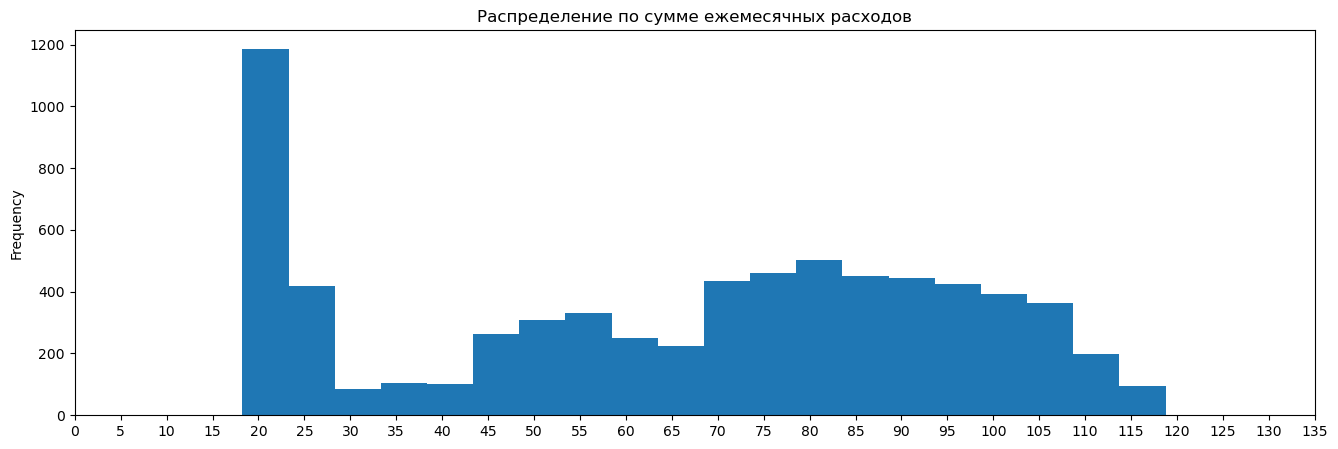

In [20]:
df_contract['MonthlyCharges'].plot(kind='hist', figsize = (16,5), xticks=np.arange(0,140,5), bins = 20)
plt.title('Распределение по сумме ежемесячных расходов')
plt.show()

По графику ежемесячных расходов видно, что преимущественная доля клиентов обслуживались по минимальному тарифу.

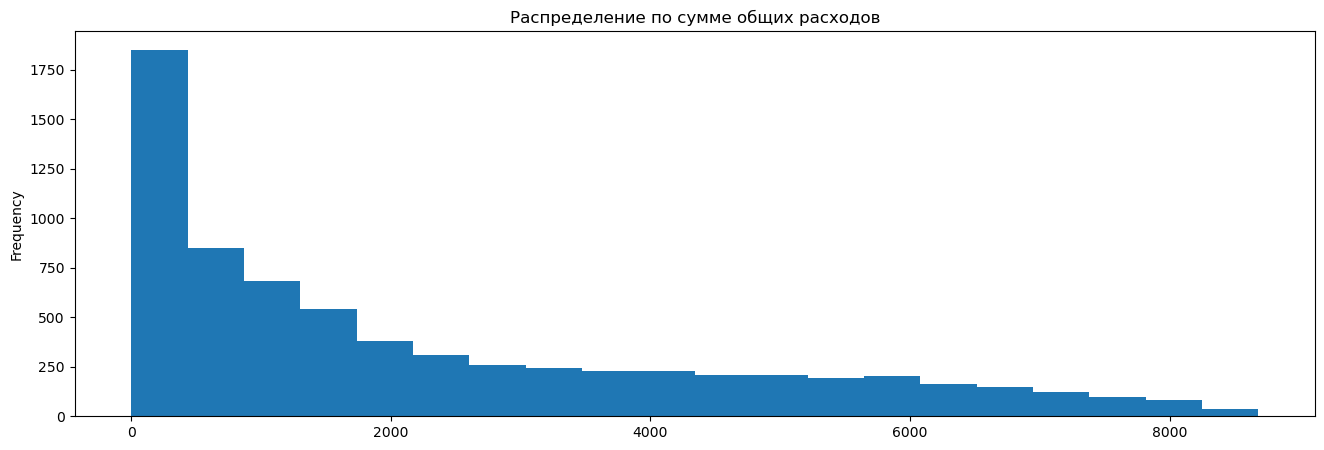

In [21]:
df_contract['TotalCharges'].plot(kind='hist', figsize = (16,5), bins = 20)
plt.title('Распределение по сумме общих расходов')
plt.show()

In [22]:
df_contract.query('TotalCharges < 50')['BeginDate'].value_counts()

2020-01-01    175
2019-12-01     78
2019-11-01     50
2019-09-01     31
2019-10-01     30
2020-02-01     11
2019-08-01      1
Name: BeginDate, dtype: int64

Существенная доля минимальных затрат за весь период объясняется большим числом новых клиентов присоединившихся за 1-2 месяца до даты среза данных.

In [23]:
df_contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [24]:
df_contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [25]:
df_contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

В столбцах *Type*, *PaperlessBilling* и *PaymentMethod* ошибок и скрытых дубликатов не обнаружено. Можно переходить к исследовательскому анализу следующей таблицы.
___

Далее изучим таблицу personal (df_personal). Согласно документации к данным эта таблица содержит информацию о персональных данных клиентов:

- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)

In [26]:
describe(df_personal)

'Первые 5 строк таблицы'

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


'##############################################'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

'##############################################'

'Описание данных'

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'##############################################'

'Количество пропусков'

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [27]:
df_personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [28]:
df_personal['SeniorCitizen'].unique()

array([0, 1])

In [29]:
df_personal['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [30]:
df_personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

По полученной информации о данных можно отметить:
   - в таблице также 7043 уникальных строки, что соответствует числу уникальных контрактов;
   - в данных отсутствуют пропуски и скрытые дубликаты;
   - все столбцы содержат данные с категориальными переменными, с некоторыми из них необходимо будет провести кодирование для обучения модели.
   
Можно переходить к исследовательскому анализу следующей таблицы.
___

Далее изучим таблицу internet(df_internet). Из документации к данным известно:

- Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

In [31]:
describe(df_internet)

'Первые 5 строк таблицы'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


'##############################################'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

'##############################################'

'Описание данных'

,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


'##############################################'

'Количество пропусков'

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

По полученной информации о данных можно отметить:
   - в таблице 5517 уникальных строк, что означает, что не все клиенты пользовались интернет услугами;
   - в данных отсутствуют пропуски и скрытые дубликаты;
   - все столбцы содержат данные с категориальными переменными, с некоторыми из них необходимо будет провести кодирование для обучения модели.
   
Можно переходить к исследовательскому анализу следующей таблицы.
___

Далее изучим таблицу phone(df_phone). Из документации к данным известно:

   - MultipleLines – наличие возможности ведения параллельных линий во время звонка

In [32]:
describe(df_phone)

'Первые 5 строк таблицы'

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


'##############################################'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

'##############################################'

'Описание данных'

,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390


'##############################################'

'Количество пропусков'

customerID       0
MultipleLines    0
dtype: int64

По полученной информации о данных можно отметить:
   - в таблице 6361 уникальная запись, что означает, что не все клиенты пользовались услугами телефонной связи;
   - в данных отсутствуют пропуски и скрытые дубликаты;
   - все столбцы содержат данные с категориальными переменными, с некоторыми из них необходимо будет провести кодирование для обучения модели.
   
На данном этапе первичный анализ данных завершен.
___

___
### Анализ данных
___

Теперь данные из разных таблиц можно объеденить. В параметре how необходимо выставить значение 'outer', чтобы не потерялись строки. Так как их количество в разных таблицах разное.

In [33]:
merged = pd.merge(df_contract, df_personal, on='customerID', how='outer')
merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No


In [34]:
merged.shape

(7043, 12)

In [35]:
df_internet.shape

(5517, 8)

In [36]:
merged = pd.merge(merged, df_internet, on='customerID', how='outer')
merged.shape

(7043, 19)

In [37]:
merged.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2658,7473-ZBDSN,2018-12-01,2020-02-01,Two year,No,Mailed check,18.80,255.55,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3935,8285-ABVLB,2014-04-01,2020-02-01,Two year,No,Credit card (automatic),19.85,1328.35,Female,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6811,8992-JQYUN,2019-11-01,2019-12-01,Month-to-month,Yes,Electronic check,50.35,50.35,Male,0,Yes,No,DSL,No,No,Yes,No,Yes,Yes
5082,8779-YIQQA,2018-05-01,2020-02-01,One year,No,Mailed check,19.80,350.10,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5231,1075-BGWOH,2018-08-01,2019-12-01,Month-to-month,Yes,Electronic check,98.75,1587.55,Male,1,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes


In [38]:
df_phone.shape

(6361, 2)

In [39]:
merged = pd.merge(merged, df_phone, on='customerID', how='outer')
merged.shape

(7043, 20)

In [40]:
merged.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
1050,1271-SJBGZ,2019-01-01,2020-01-01,Month-to-month,Yes,Electronic check,43.65,526.95,Male,1,No,No,DSL,No,No,Yes,Yes,No,Yes,NaN
3173,9766-HGEDE,2018-09-01,2020-02-01,One year,No,Mailed check,19.35,307.00,Female,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3761,9385-NXKDA,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),82.65,5919.35,Female,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Yes
6661,3704-IEAXF,2014-02-01,2020-02-01,Two year,No,Credit card (automatic),53.65,3784.00,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,Yes,NaN
3709,2103-ZRXFN,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,50.75,50.75,Male,0,No,No,DSL,No,No,No,No,No,No,Yes


In [41]:
merged.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
5690,0336-KXKFK,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),61.20,4390.25,Male,0,No,No,DSL,Yes,No,Yes,Yes,Yes,Yes,NaN
3356,2235-ZGKPT,2019-06-01,2019-10-01,Month-to-month,No,Mailed check,50.85,239.55,Female,0,Yes,Yes,DSL,No,No,No,No,No,No,Yes
2809,4360-QRAVE,2017-01-01,2020-02-01,Month-to-month,No,Electronic check,36.65,1315.00,Male,1,No,No,DSL,No,Yes,Yes,No,No,No,NaN
4782,6175-IRFIT,2019-09-01,2020-02-01,Month-to-month,No,Mailed check,78.75,426.35,Male,0,No,No,Fiber optic,No,No,No,No,No,Yes,No
1090,9036-CSKBW,2015-11-01,2020-02-01,One year,No,Bank transfer (automatic),107.45,5680.90,Female,0,No,No,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Yes


Теперь определим не было ли в таблицах *df_internet* и *df_phone customerID* которых не было в таблицах *df_contract и df_personal*. В этом случае, в столбцах из *df_contract и df_personal* должны появится *Nan*.

In [42]:
for i in ('Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
          'SeniorCitizen', 'Partner', 'Dependents'):
    print(merged[i].isna().sum())

0
0
0
0
0
0
0
0
0


Значений Nan в проверенных столбцах нет, значит в df_contract и df_personal были все имеющиеся уникальные клиенты, но некоторые из них не пользовались услугами интернета или телефонной связи от оператора.
Таким образом, значения Nan в столбцах по интернет услугам и столбце *MultipleLines* (по сути во всей таблице) можно заменить на No, что не противоречит применяемой логике.

In [43]:
merged = merged.fillna('No')
merged.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Столбцы *BeginDate* и *EndDate* впоследствии позволят сформировать значения Target для модели. И, вероятнее всего, будут приводить к утечке данных поэтому их придется удалить. При этом можно использовать разницу между датами как один из признаков.

In [44]:
merged['contractPeriod'] = (merged['EndDate'] - merged['BeginDate']).dt.days

In [45]:
merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractPeriod
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61


Создадим целевой признак:

In [46]:
def target (EndDate):
    if EndDate != datetime(2020, 2, 1):
        return 1
    else:
        return 0

In [47]:
merged['Target'] = merged.apply(lambda x: target(x.EndDate), axis=1)

In [48]:
merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractPeriod,Target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,1


In [49]:
merged = merged.drop(['BeginDate', 'EndDate'], axis=1)

In [50]:
merged.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractPeriod,Target
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,0
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,1
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,1


Столбец *customerID* судя по всему формируется рандомно и является уникальным для каждого клиента, в том числе и для будущих клиентов. Поэтому не может оказывать влияния на целевой признак. Его можно удалить.

In [51]:
merged = merged.drop('customerID', axis=1)
merged.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractPeriod,Target
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,0
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,1
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,1


Создадим инструмент для кодирования категориальных признаков:

In [52]:
encoder = OrdinalEncoder()
merged_ordinal = merged
merged_ordinal[['Type','PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner',
               'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
              'MultipleLines']] = encoder.fit_transform(merged_ordinal[['Type',
                                                                      'PaperlessBilling',
                                                                      'PaymentMethod', 'gender',
                                                                      'SeniorCitizen', 'Partner',
               'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
              'MultipleLines']])
merged_ordinal.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractPeriod,Target
0,0.0,1.0,2.0,29.85,29.85,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,31,0
1,1.0,0.0,3.0,56.95,1889.50,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1036,0
2,0.0,1.0,3.0,53.85,108.15,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,61,1
3,1.0,0.0,0.0,42.30,1840.75,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1371,0
4,0.0,1.0,2.0,70.70,151.65,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61,1


Следующим этом можно изучить зависимость признаков друг от друга.

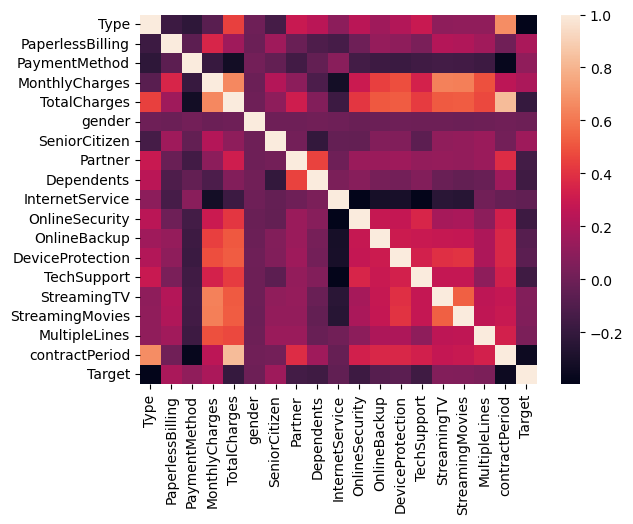

In [53]:
corr = merged_ordinal.corr()
sns.heatmap(corr)
plt.show()

Здесь видно, что столбы с числовыми данными *contractPeriod* и *TotalCharges* имеют наименьшую корреляцию с целевой переменной. Можно иметь это ввиду на этапе изучения важности параметров для моделей.

Также видно, что услуги *OnlineBackup*, *DeviceProtection*, *TechSupport*, *StreamingTV*, *StreamingMovies* и *MultipleLines* предоставлялись оператором не бесплатно и влияли на показатели ежемесячных и общих расходов клиентов.

### Написание модели

Для более удобного создания моделей напишем функции:

In [54]:
def make_features_target (data, target_col='Target'):
    features = data.drop(target_col, axis=1)
    target = data[target_col]
    return features, target

In [55]:
def split_data (features, target):
    features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                                test_size=0.2,
                                                                                random_state = random_state)
    scaler = StandardScaler()
    numeric = ['MonthlyCharges', 'TotalCharges', 'contractPeriod']
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_test, target_train, target_test

Разделим датасет на выборки:

In [56]:
pd.options.mode.chained_assignment = None

In [57]:
features, target = make_features_target(merged_ordinal)
features_train, features_test, target_train, target_test = split_data(features, target)

#### LogisticRegression

Для логистической регрессии необходимо изучить данные на предмет наличия мультиколлинеарности:

In [58]:
vif_scores = pd.DataFrame()
vif_scores['Atrribute'] = features.columns

vif_scores['VIF scores'] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]
display(vif_scores)

,Atrribute,VIF scores
0,Type,4.078135
1,PaperlessBilling,2.874230
2,PaymentMethod,2.970294
3,MonthlyCharges,16.166061
4,TotalCharges,14.297280
5,gender,1.947504
6,SeniorCitizen,1.361945
7,Partner,2.819666
8,Dependents,1.955419
9,InternetService,3.367112


Столбцы *MonthlyCharges*, *TotalCharges*, *contractPeriod* имеют значение повышенное значение и должны быть удалены для устранения мультиколлинеарности.

In [59]:
features_lr = features.drop(['contractPeriod', 'MonthlyCharges', 'TotalCharges'], axis=1)

In [60]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(features_lr, target,
                                                                                       test_size = 0.2,
                                                                                       random_state = random_state)

In [61]:
lr_CV = LogisticRegressionCV(cv = 10, scoring = 'roc_auc', n_jobs = -1)
lr_CV.fit(features_train_lr, target_train_lr)

probabilities_lrCV_test = lr_CV.predict_proba(features_test_lr)
probabilities_lrCV_one_test = probabilities_lrCV_test[:,1]

roc_auc_score(target_test_lr, probabilities_lrCV_one_test)

0.8120417201378929

**Значение auc-roc полученное при помощи Логистической регрессии составило 0,81, можно учесть его как базовый уровень.**

#### RandomForestClassifier

In [62]:
rfc = RandomForestClassifier(class_weight = 'balanced', n_estimators = 30, max_depth = 6,
                               random_state = random_state)

parameters = {'n_estimators': [10, 100, 200],
             'max_depth': [2, 6, 8],
             'max_features': [2, 6, 12]}

Grid_rfc = GridSearchCV(estimator = rfc, param_grid = parameters, scoring = 'roc_auc', cv = 5, refit=True)
rf_result = Grid_rfc.fit(features_train, target_train)

print("\n Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_rfc.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_rfc.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_rfc.best_params_)


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=12,
                       n_estimators=200, random_state=80822)

 The best score across ALL searched params:
 0.8665386315765684

 The best parameters across ALL searched params:
 {'max_depth': 8, 'max_features': 12, 'n_estimators': 200}


In [63]:
rfc_model = RandomForestClassifier(**Grid_rfc.best_params_)
rfc_model.fit(features_train, target_train)
probabilities_rfc_test = rfc_model.predict_proba(features_test)
rfc_model_one_test = probabilities_rfc_test[:,1]

rfc_roc_auc = roc_auc_score(target_test, rfc_model_one_test)
print(rfc_roc_auc)

0.8712828061699505


Случайный лес показал более высокое значение auc-roc без учета оценки важности параметров. Проведем такую оценку и посмотрим, как изменится требуемый показатель:

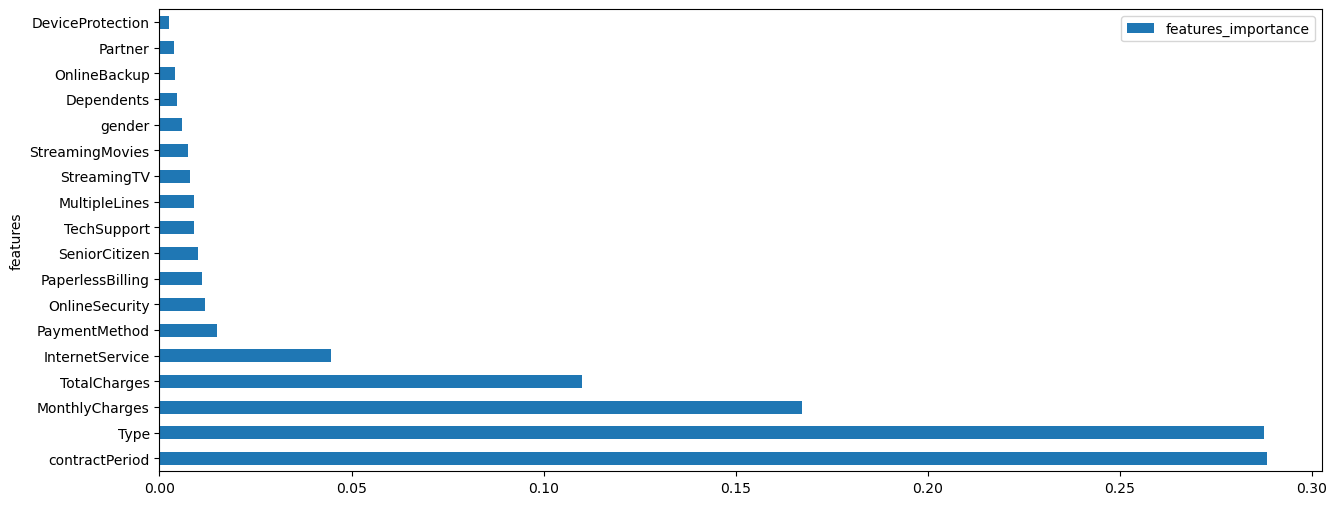

In [64]:
rfc_feature_importances = pd.DataFrame({'features':features_train.columns,
                                   'features_importance':rfc_model.feature_importances_}).sort_values(
    'features_importance', ascending=False)
rfc_feature_importances.set_index('features').plot(kind='barh', figsize=(15,6))
plt.show()

Таким образом, можно увидеть, что наибольшее влияние имеют столбцы *contractPeriod*, *Type*, *MonthlyCharges*, *TotalCharges*, *InternetService*. 
Пропробуем убрать остальные столбцы и переучить модель.

In [65]:
rfc_features = features.drop(['DeviceProtection', 'Partner', 'OnlineBackup',
                              'gender', 'Dependents', 'StreamingMovies', 'StreamingTV',
                             'MultipleLines', 'TechSupport', 'SeniorCitizen', 'PaperlessBilling',
                                 'OnlineSecurity', 'PaymentMethod'], axis = 1) 
rfc_features_train, rfc_features_test, rfc_target_train, rfc_target_test = split_data(rfc_features, target)

In [66]:
rfc_fi = RandomForestClassifier(class_weight = 'balanced', n_estimators = 30, max_depth = 6,
                               random_state = random_state)

parameters = {'n_estimators': [10, 100, 200],
             'max_depth': [2, 6, 8],
             'max_features': [0.1, 0.25, 0.5]}

Grid_rfc_fi = GridSearchCV(estimator = rfc_fi, param_grid = parameters, scoring = 'roc_auc', cv = 5, refit=True)
rf_result_fi = Grid_rfc_fi.fit(rfc_features_train, rfc_target_train)

print("\n Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_rfc_fi.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_rfc_fi.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_rfc_fi.best_params_)


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=0.5,
                       random_state=80822)

 The best score across ALL searched params:
 0.8631877741413934

 The best parameters across ALL searched params:
 {'max_depth': 8, 'max_features': 0.5, 'n_estimators': 100}


In [67]:
rfc_model_fi = RandomForestClassifier(**Grid_rfc_fi.best_params_)
rfc_model_fi.fit(rfc_features_train, rfc_target_train)
probabilities_rfc_test_fi = rfc_model_fi.predict_proba(rfc_features_test)
rfc_model_one_test_fi = probabilities_rfc_test_fi[:,1]

rfc_roc_auc = roc_auc_score(rfc_target_test, rfc_model_one_test_fi)
print(rfc_roc_auc)

0.8709179436853627


По итогам проведенных действий значение auc-roc практически не изменилось и составило **0,87 с помощью модели RandomForestClassifier.**

#### CatBoostClassifier

In [73]:
cbc = CatBoostClassifier()
parameters = {'depth' : [4, 5, 6, 7, 8, 9, 10],
             'learning_rate': [0.05, 0.1, 0.5, 1],
             'iterations': [1, 5, 10, 15, 20, 25, 30]}
Grid_cbc = GridSearchCV(estimator = cbc, param_grid = parameters, scoring = 'roc_auc', cv = 5, n_jobs = -1)
Grid_cbc.fit(features_train, target_train, logging_level='Silent')

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_cbc.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_cbc.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_cbc.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.8835231920104649

 The best parameters across ALL searched params:
 {'depth': 4, 'iterations': 30, 'learning_rate': 1}


In [74]:
cbc_model = CatBoostClassifier(**Grid_cbc.best_params_)
cbc_model.fit(features_train, target_train)
probabilities_cbc_test = cbc_model.predict_proba(features_test)
cbc_model_one_test = probabilities_cbc_test[:,1]

cbc_roc_auc = roc_auc_score(target_test, cbc_model_one_test)
print(cbc_roc_auc)

0:	learn: 0.4653337	total: 2.9ms	remaining: 84.2ms
1:	learn: 0.4229403	total: 6.08ms	remaining: 85.2ms
2:	learn: 0.4098913	total: 7.14ms	remaining: 64.2ms
3:	learn: 0.3958347	total: 8.36ms	remaining: 54.4ms
4:	learn: 0.3892562	total: 9.96ms	remaining: 49.8ms
5:	learn: 0.3854359	total: 11.2ms	remaining: 45ms
6:	learn: 0.3818996	total: 12.2ms	remaining: 40.2ms
7:	learn: 0.3773543	total: 13.7ms	remaining: 37.8ms
8:	learn: 0.3726027	total: 14.5ms	remaining: 33.9ms
9:	learn: 0.3677258	total: 15.3ms	remaining: 30.6ms
10:	learn: 0.3661928	total: 16.1ms	remaining: 27.8ms
11:	learn: 0.3579812	total: 16.9ms	remaining: 25.3ms
12:	learn: 0.3552811	total: 18.2ms	remaining: 23.8ms
13:	learn: 0.3526613	total: 19ms	remaining: 21.7ms
14:	learn: 0.3505708	total: 19.9ms	remaining: 19.9ms
15:	learn: 0.3488212	total: 20.7ms	remaining: 18.1ms
16:	learn: 0.3444922	total: 21.4ms	remaining: 16.4ms
17:	learn: 0.3366895	total: 22.2ms	remaining: 14.8ms
18:	learn: 0.3337036	total: 23ms	remaining: 13.3ms
19:	learn:

Модель CatBoostClassifier дала оценку ~0,89 без учета влияния важности параметров. Изучим наличия подобного влияния и переобучим модель.

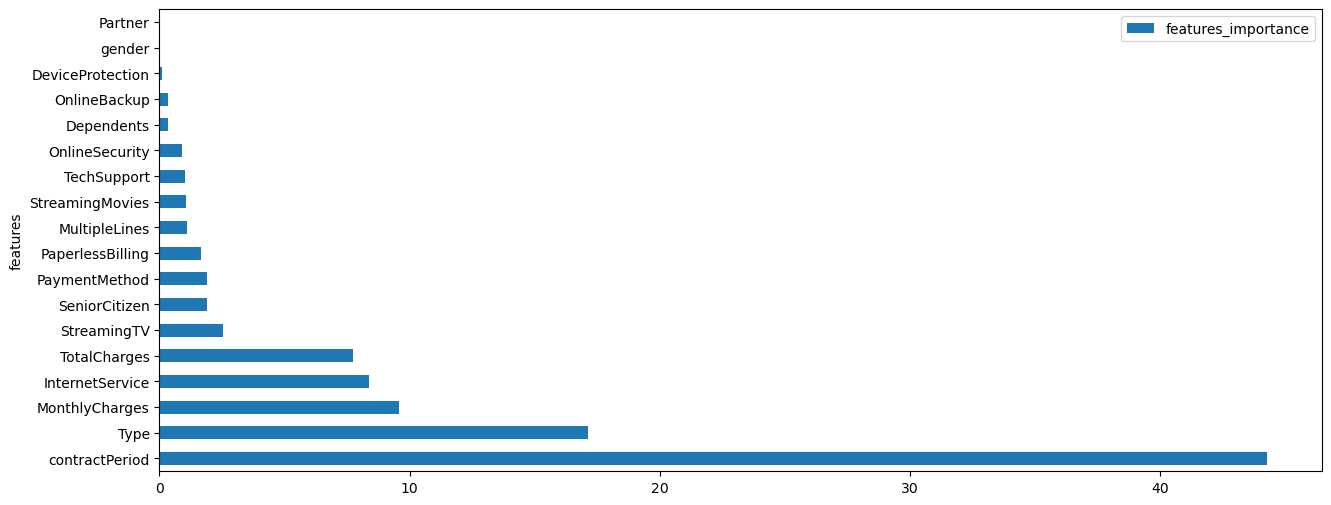

In [75]:
cbc_feature_importances = pd.DataFrame({'features':features_train.columns,
                                   'features_importance':cbc_model.feature_importances_}).sort_values(
    'features_importance', ascending=False)
cbc_feature_importances.set_index('features').plot(kind='barh', figsize=(15,6))
plt.show()

In [76]:
cbc_features = features.drop(['DeviceProtection', 'Partner','gender'], axis = 1) 
cbc_features_train, cbc_features_test, cbc_target_train, cbc_target_test = split_data(cbc_features, target)

In [80]:
cbc_fi = CatBoostClassifier()
parameters = {'depth' : [4, 5, 6, 7, 8, 9, 10],
             'learning_rate': [0.05, 0.1, 0.5, 1],
             'iterations': [1, 5, 10, 15, 20, 25, 30]}
Grid_cbc_fi = GridSearchCV(estimator = cbc_fi, param_grid = parameters, scoring = 'roc_auc', cv = 5, n_jobs = -1)
Grid_cbc_fi.fit(cbc_features_train, cbc_target_train, logging_level='Silent')

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_cbc_fi.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_cbc_fi.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_cbc_fi.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.8876662598473161

 The best parameters across ALL searched params:
 {'depth': 4, 'iterations': 30, 'learning_rate': 1}


In [78]:
cbc_model_fi = CatBoostClassifier(**Grid_cbc_fi.best_params_)
cbc_model_fi.fit(cbc_features_train, cbc_target_train)
probabilities_cbc_test_fi = cbc_model_fi.predict_proba(cbc_features_test)
cbc_model_one_test_fi = probabilities_cbc_test_fi[:,1]

cbc_roc_auc_fi = roc_auc_score(cbc_target_test, cbc_model_one_test_fi)
print(cbc_roc_auc_fi)

0:	learn: 0.4567942	total: 2.35ms	remaining: 68.2ms
1:	learn: 0.4199162	total: 4.09ms	remaining: 57.3ms
2:	learn: 0.3991105	total: 4.99ms	remaining: 44.9ms
3:	learn: 0.3939088	total: 5.92ms	remaining: 38.5ms
4:	learn: 0.3903070	total: 6.77ms	remaining: 33.9ms
5:	learn: 0.3865061	total: 7.71ms	remaining: 30.8ms
6:	learn: 0.3842556	total: 8.57ms	remaining: 28.2ms
7:	learn: 0.3796148	total: 9.6ms	remaining: 26.4ms
8:	learn: 0.3755269	total: 10.4ms	remaining: 24.3ms
9:	learn: 0.3703556	total: 11.2ms	remaining: 22.4ms
10:	learn: 0.3673572	total: 12ms	remaining: 20.8ms
11:	learn: 0.3590857	total: 12.9ms	remaining: 19.3ms
12:	learn: 0.3563061	total: 13.8ms	remaining: 18ms
13:	learn: 0.3487791	total: 14.6ms	remaining: 16.7ms
14:	learn: 0.3474975	total: 15.4ms	remaining: 15.4ms
15:	learn: 0.3445013	total: 16.2ms	remaining: 14.2ms
16:	learn: 0.3398966	total: 17.4ms	remaining: 13.3ms
17:	learn: 0.3334622	total: 18.4ms	remaining: 12.3ms
18:	learn: 0.3300851	total: 19.3ms	remaining: 11.2ms
19:	lear

По итогам устранения менее важных параметров модель **CatBoostClassifier дала наиболее высокое значение метрики roc-auc = 0.9**

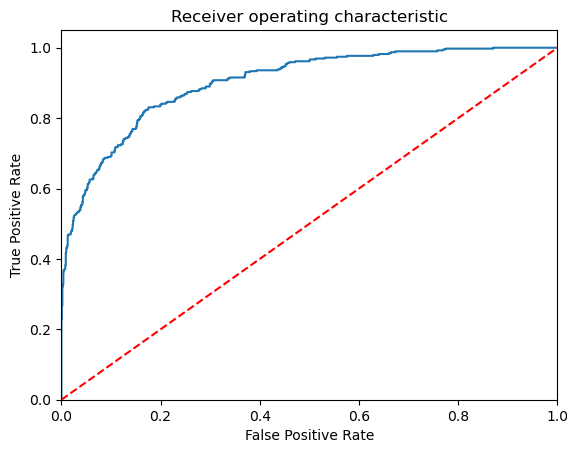

In [79]:
cbc_roc_auc_curve = roc_auc_score(cbc_target_test, cbc_model_fi.predict(cbc_features_test))
fpr, tpr, thresholds = roc_curve(cbc_target_test, cbc_model_fi.predict_proba(cbc_features_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='CatBoostClassifier (area = %0.2f)' % cbc_roc_auc_curve)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.savefig('Log_ROC')
plt.show()

### Итоговый отчет

#### Описание задачи

___
___
От компании оператора связи «Ниединогоразрыва.ком» поступил запрос на модель, которая могла бы прогнозировать отток клиентов с целью его минимизации. В случае, если выясняется, что пользователь планирует уйти, ему могут быть предложены промокоды и специальные условия для удержания.

Командой оператора были собраны персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание данных**:
Данные состоят из файлов, полученных из разных источников:

- contract.csv — информация о договоре;
- personal.csv — персональные данные клиентов;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии.


Во всех файлах столбец customerID содержит уникальный код клиента.
Информация о договорах актуальна на 1 февраля 2020.

**Целевая метрика точности модели по условиям заказчика**- ROC-AUC не ниже 0,75.

#### Описание полученных исходных данных

Заказчик передал для построения моделей данные пользователей в 4 различных файлах.
___

Первый файл с информацией о заключенных с клиентами контрактах (*contract*) содержал 7043 уникальные строки, что эквивалентно 7043 уникальным клиентам. В таблице имеются данные:

 - Начала и конца срока действия договора с клиентом;
 - Тип оплаты по контракту (ежемесячный, годовой);
 - Использование безналичных расчетов;
 - Способ оплаты;
 - Ежемесячные и общие траты на услуги.
 
При изучении ежемесячных затрат было обнаружено, что большая часть клиентов пользовались минимальным по стоимости тарифом. Общая сумма затрат большинства клиентов в связи с этим была невелика. Также невысокие общие затраты большинства клиентов объяснялись недавним подключением к услугам оператора.

<div>
<img src="https://i.postimg.cc/4NNB6fFN/1.png" width="1000"/>
</div>

 ___
 В файле с названием *personal* указана персональная информация о клиентах. В данных также 7043 строки с соответствующими уникальными номерами. Помимо этого в таблице имеется информация о:
 
 - поле клиента;
 - наличии пенсионного статуса по возрасту;
 - наличии супруга(и);
 - наличии иждивенцев.
 ___
 Далее в файле под названием *internet* содержалась информация об использовании клиентами услуг в сети интернет, в том числе:
 
 - Тип подключения;
 - интернет-безопасность: антивирус;
 - блокировка небезопасных сайтов;
 - Выделенная линия технической поддержки;
 - Облачное хранилище файлов для резервного копирования данных;
 - Стриминговое телевидение и каталог фильмов.
 
 В данной таблице содержалось 5517 строк, что означало, что услугами компании в сети интернет пользовалось лишь 78% всех клиентов за рассматриваемый период.
 ___
 
 В таблице *phone* также было представлено меньшее количество клиентов - 6361 уникальный пользователь. Таким образом доля клиентов компании пользовавшихся услугами телефонной связи составила порядка 90%, что превышает долю клиентов использующих услуги компании в интернете на 12%. При этом, следует понимать, что часть клиентов входит в обе выборки и пользуется как услугами телефонии, так и сервисами компании в интернете.
 
 В таблице *phone* помимо уникального номера клиента представлена информация о наличии у него возможности ведения параллельных линий во время звонка.
 ___
 ___

#### Описание ошибок и неточностей в данных

___
___
Наибольший объем необходимых действий по предобработке потребовался при работе с данными по имеющимся контрактам (*contract*):

 - все столбцы кроме MonthlyCharges имели формат object, в том числе столбец с численными данными *TotalCharges* и столбцы с датами 
 - в столбце EndDate присутствовали значения "No", что означало, что контракт действовал на 1 февраля 2020 года.
 - также в столбце EndDate значилось всего 4 уникальные даты. Вероятно оператор обновлял статус контрактов в эти даты.
 - в столбце *TotalCharges* для части пользователей отсутствовали значения. Для них была характерна дата начала действия контракта в феврале 2020, то есть на момент среза данных. Таким образом они не успели понести затрат, но отсутствующие значения в дальнейшем целесообразно было заменить на 0 во избежание появления ошибок.
 - в файле по контрактам с клиентами отсутствовал целевой признак, подверждающий факт ухода клиента от оператора. Таким образом за данный признак необходимо было воспринять дату окончания контракта с клиентом. Отсутствие даты окончания контракта означало, что клиент не ушел.
 - наличие даты окончания договора была проставлена примерно у четверти клиентов, что означало, что данные несбалансированы;  
 - скрытых дубликатов или выбивающихся значений (выбросов) в файле обнаружено не было.
 
В остальных исходных файлах (*personal*,*internet*,*phone*) содержащих исключительно категорииальные признаки  также не было обнаружено пропусков, скрытых дубликатов. Единственный момент, требующий отдельного внимания в дальнейшей работе - разное количество строк в разных файлах, что при неосторожности может привести к потере данных.
 
___
___

#### Описание произведенных действий с данными

___
___

На данном этапе были произведены действия направленные на устранение недостатков в файле с информацией о контрактах выявленных на предыдущем этапе:
 - Формат столбца *TotalCharges* был изменен на числовой, столбцов *BeginDate* и *EndDate* на формат дат;
 - Значения "No" в столбце *EndDate* были заменены на дату среза данных - 2020-02-01;
 - В столбце *TotalCharges* пропущенные значения для новых клиентов были заменены на нулевые значения;
___
___

#### Описание произведенных действий для написания модели

Устранив найденные в данных неточности и несоответствия следующим этапом были проведены действия направленные на создания условий для написания моделей прогнозирования.

 - В первую очередь данные из разных файлов были объединены в один датасет. Объединение было произведено с использованием метода **merge** с параметров *how='outer'* во избежание потерь данных. После каждого объединения проводилась проверка общего размера объединеной таблицы.
 

 - Следующим и наиболее важным из этих действий было создание целевого признака, так как изначально он отсутствовал в явном виде. Как заранее было определено, целевой признак был создан из столбца *EndDate* - даты окончания действия договора с клиентом. Таким образом бинарный признак (1,0) был создан по следуюдщей логике:
>   Если в столбце *EndDate* файла *contracts* есть любая дата отличная от 2020-02-01 (дата среза добавленная вручную на этапе обработки данных), признак был равен 1 ("клиент ушел"). Если дата была равна 2020-02-01, признак был равен 0 ("клиент не ушел").
    
 - Из столбцов c датой начала действия договора и его окончания (*BeginDate*, *EndDate*) было решено извлечь параметр *contractPeriod* который был обозначал продолжительность действия договора и рассчитывался как разница между датами начала и окончания в днях.
 
 
 - Далее столбцы с датой начала действия договора и датой окончания действия договора были удалены, так как необходимые признаки из них были извлечены, а сами эти столбцы могли привести к утечке данных при обучении.    
 - Столбец customerID являлся уникальным для каждого клиента, в том числе и для будущих клиентов. Поэтому не мог оказывать влияния на целевой признак. Было принято решение его можно удалить.
 
 - Часть данных в объединенном датасете были представленны категориальными переменными: 
 > ('Type','PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner','Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','MultipleLines')
 
    Эти признаки для дальнейшего обучения моделей были закодированы в числовой формат с использованием Ordinal  Encoder.
    

 - Для изучения корреляции данных была построена матрица корреляции, показавшая, что столбы с числовыми данными contractPeriod и TotalCharges имели наименьшую корреляцию с целевой переменной.

<div>
<img src="https://i.postimg.cc/44w1xCNC/2022-08-19-01-07-57.png" width="500"/>
</div>

___
Выполнив данные действия полученный датасет был разделен на обучающую и тестовую выборки. **Размер тестовой выборки составил 20%.**
Непосредственно после разделения выборки был применен инструмент StandardScaler для приведения численных данных к одному порядку.
___

После проведенных действий были написаных 3 разных типа моделей прогнозирования:
 - **LogisticRegression**
 - **RandomForest**
 - **CatboostClassifier**
 
При написании каждой из моделей применялась кросс-валидация.
 ___

 **LogisticRegression**
 
Для модели Логистической регрессии также предварительно была проведена проверка на наличие мультиколлинераности, по итогам которой для данной модели были исключены признаки ('contractPeriod', 'MonthlyCharges', 'TotalCharges').


По итогам проведенных действий **Логистическая регрессия показала точность целевого показателья ROC-AUC на тестовой выборке - 0,81**
___

**RandomForest**

**Данная модель по итогам обучения показала точность целевого показателья ROC-AUC на тестовой выборке - 0,87**
Изучение важности параметров показало, что наибольшее влияние имеют столбцы contractPeriod, Type, MonthlyCharges, TotalCharges, InternetService. Было решено убрать остальные столбцы и переобучить модель повторно. Проведенные действия не привели к повышению точности предсказания модели - ROC-AUC остался равен - 0,87.
___

**Catboost**

Модель Catboost дала прогноз с точностью целевого показателья ROC-AUC на тестовой выборке - 0,89 Аналогичное изучение важности параметров показало, что наименьшее влияние имеют столбцы *'DeviceProtection', 'Partner','gender'*. После удаления данных столбцов и повторного переобучения **точность предсказания модели CatBoostClassifier по метрике ROC-AUC возросла до 0,90.**
___

#### Аргументация выбора итоговой модели

|№      |     Модель     |     ROC-AUC на тестовой выборке     |
|:-----|:----:|----:|
|1 |LogisticRegression |0,81 |
|2 |RandomForest |0,87 |
|3 |CatboostRegression |0,9 |

По результатам сравнения можно увидеть, что наиболее высокую точность дает CatBoostClassifier. Соответственно для итоговой рекомендации стоит выбрать ее.

#### Резюме проведенной работы, рекомендации заказчику по дальнейшей работе с моделью.

По запросу заказчика были изучены и предобработаны данные для предсказания о потенциально потерянных клиентах.
На основании обработанных данных были изучены зависимости между ними и добавлены потенциально важные расчетные показатели.
На основании полученного датафрейма были построены 3 различных модели предсказания. Модели показали существенно отличающуюся точность целевой метрики. Наиболее точный результат дала модель CatboostClassifier. Точность прогноза по заданной целевой метрике превышает вырнюю отметку желаемой заказчиком точности в связи с чем бизнесу рекомендуется использовать данную модель на реальных релевантных данных.